In [87]:
import sys
sys.path.append('code/transethnic_prs-main/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transethnic_prs.model1.Model1Blk as model1blk
from transethnic_prs.model1.Model1Helper import get_lambda_seq
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from sklearn.linear_model import ElasticNetCV

#gene = sys.argv[1]
#gene_name = sys.argv[2]

gene = 'ENSG00000128185.5'
gene_name = 'DGCR6L'


def data_processing(gene, gene_name):
    # read eur and afr sample info
    eur_sample = pd.read_csv('data/clean/' + gene_name + '_genotype/eur_' + gene_name + '_genotype.012.indv', sep='\t',
                             header=None)
    afr_sample = pd.read_csv('data/clean/' + gene_name + '_genotype/afr_' + gene_name + '_genotype.012.indv', sep='\t',
                             header=None)

    # load 2 genotype matrices
    eur_genotype = pd.read_csv('data/clean/' + gene_name + '_genotype/eur_' + gene_name + '_genotype.012', sep='\t',
                               header=None, index_col=0)
    afr_genotype = pd.read_csv('data/clean/' + gene_name + '_genotype/afr_' + gene_name + '_genotype.012', sep='\t',
                               header=None, index_col=0)

    # extract target phenotype vector
    pheno_total = pd.read_csv('data/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt', sep='\t', index_col='TargetID')
    target_pheno_total = pheno_total.loc[gene]
    target_pheno_eur = pd.merge(target_pheno_total, eur_sample, left_index=True, right_on=0)
    target_pheno_afr = pd.merge(target_pheno_total, afr_sample, left_index=True, right_on=0)
    pa = target_pheno_afr.set_index(0)
    pe = target_pheno_eur.set_index(0)

    # make sure the sample order of phenotype vector is the same as genotype matrix's
    sorted_eur_pheno = pd.merge(eur_sample, pe, left_on=0, right_index=True, how='left')
    sorted_afr_pheno = pd.merge(afr_sample, pa, left_on=0, right_index=True, how='left')

    return eur_genotype, afr_genotype, sorted_eur_pheno, sorted_afr_pheno

def check_nan(x):
    count = 0
    for x in x.describe().loc['min']:
        if x == -1: # vcftools outputs nan genotypes as -1
            count+=1
    return count

def SNP_var_check(X): # check SNPs whoes variance=0 and output valid SNPs index
    col_valid = []
    count = 0
    for col,x in enumerate(np.std(X, axis = 0)):
        if x==0:
            count +=1
        else:
            col_valid.append(col)
    return col_valid, count

def standardization(x):
    x=np.array(x,dtype = np.float64,order = 'C')
    x_center = x - np.mean(x,axis = 0)
    return x_center/np.std(x, axis = 0)

def test(y_hat_test, pop):
    # validate the final result on AFR test set.
    # standardize the calculated y_hat_test
    y_hat_test = (y_hat_test-y_hat_test.mean())/y_hat_test.std()
    # give correlation matrix between y_hat_test and y_test_std(standardized true y_test)
    correlation_test_matrix = np.corrcoef(y_hat_test, y_test_std)
    correlation_test = correlation_test_matrix[0,1]# this is the pearson r
    r2 = correlation_test**2 #pearson r2
    # fit a line using OLS to plot and m should equal r
    m, b = np.polyfit(y_test_std, y_hat_test, 1)
    # spearman correlation r
    sp_r, _ = spearmanr(y_hat_test,y_test_std)
    #plot
    plt.title(gene_name + ' based on' + pop + "'s info")
    plt.xlabel('observation')
    plt.ylabel('prediction')
    plt.axis([-2.5,2.5,-3,3])
    plt.scatter(y_test_std, y_hat_test, color="blue")
    plt.plot(y_test_std, m * y_test_std + b)
    plt.text(-2, 2.5, f"pearson R2 = %f" % r2)
    plt.text(-2, 2.2, f"spearman R2 = %f" % sp_r**2)
    plt.savefig('result/' + gene_name + '_' + pop + '_pearsonR2_CV_plot.png')
    plt.close()
    return r2,m,sp_r**2,sp_r

eur_genotype, afr_genotype, sorted_eur_pheno, sorted_afr_pheno = data_processing(gene, gene_name)

# check and count the number of missing genotypes in Eur and Afr.
nan_eur = check_nan(eur_genotype)
nan_afr = check_nan(afr_genotype)

# inpute nan with each SNP's mean value
f = lambda x : x.replace(-1,x.mean())
eur_genotype = eur_genotype.apply(f, axis = 'index')
afr_genotype = afr_genotype.apply(f, axis = 'index')

# original matrix(before standardization)
X1o = np.array(eur_genotype,dtype = np.float64,order = 'C')
X2o = np.array(afr_genotype,dtype = np.float64,order = 'C')
y1o = np.array(sorted_eur_pheno[gene],dtype = np.float64,order = 'C')
y2o = np.array(sorted_afr_pheno[gene],dtype = np.float64,order = 'C')

# step1:find invalid SNPs in original afr matrix and get 1st valid SNP set on non-split whole sample set.
col_valid1,count1 = SNP_var_check(X2o)

# step2:split 1st filtered X2o into training set and test set
X_train,X_test,y_train,y_test = train_test_split(X2o,y2o,test_size = 0.2, random_state = 0,shuffle = False)

# step3: find invalid SNPs in test set and filter them out and get 2nd valid SNP set on test set.
col_valid2,count2 = SNP_var_check(X_test)

# step4: KFold = 5
kf = KFold(n_splits=5)#without shuffling, the random state is immutable.

# step5: pre-CV to find intersection of valid SNPs and get 3nd valid SNP set on whole training set. (including training set and validation set in each fold).
i = 1
for train_index, test_index in kf.split(X_train):
    train_index = list(train_index)
    test_index = list(test_index)
    X_to, X_vo = X_train[train_index, :], X_train[test_index, :]
    y_to, y_vo = y_train[train_index], y_train[test_index]
    col_valid_train, count_train = SNP_var_check(X_to)# valid SNPs on training set
    col_valid_valid, count_valid = SNP_var_check(X_vo)# valid SNPs on validation set
    col_valid3 = list(set(col_valid_train).intersection(set(col_valid_valid)))
    globals()['col_set%s' % i] = col_valid3
    i+=1

# intersection of valid SNP indexes in all 5 fold
valid_col_trainset = list(set(col_set1).intersection(col_set2).intersection(col_set3).intersection(col_set4).intersection(col_set5))

# step6: produce final valid SNP set on intersections generated by test set, training sets and validation sets.
col_valid_final = list(set(col_valid1).intersection(col_valid2).intersection(valid_col_trainset))
# ps: here intersecting with col_valid1 is not necessary, the final set is the same with or without it.

# choose the valid subset of EUR matrix, standardize it and generate summary statistics.
X1o = X1o[:, col_valid_final]
X1, y1 = standardization(X1o), standardization(y1o)
A1 = X1.T @ X1
b1 = X1.T @ y1
# A1 and b1 can also be generated using summary statistics such as LD matrix and marginal effect size vector. Results are identical.

# choose the valid subset of AFR test set, standardize it.
X_test = X_test[:, col_valid_final]
X_test_std = standardization(X_test)
y_test_std = standardization(y_test)


'''
Eur + Afr model
Using Yanyu's lasso and EN solver.
5fold CV for hyperparameter lambda and estimator beta_hat
'''

def r2_score(beta_mat):
    # use pearson R2 to score
    Max2 = 0
    for i in range(100):
        beta_hat = beta_mat[:, i]
        y_v_hat = X_v_std @ beta_hat
        correlation_matrix = np.corrcoef(y_v_hat, y_v_std)
        r = correlation_matrix[0, 1]
        r2 = r ** 2
        if r2 > Max2:
            Max2 = r2 # Max2 is the largest r2 in one fold among all r2s generated by every weight decay separately
            idx = i
    return Max2, idx



In [79]:
def MSE_score(beta_mat):
    # use MSE between y and y_hat to score
    mse_list = []
    Min2 = 100
    for i in range(100):
        beta_hat = beta_mat[:, i]
        y_v_hat = X_v_std @ beta_hat
        MSE = mean_squared_error(y_v_std, y_v_hat)
        mse_list.append(MSE)
        if MSE < Min2:
            Min2 = MSE  # Min2 is the smallest MSE in one fold among all MSEs generated by every weight decay separately
            idx = i
       
    return Min2, idx, mse_list

In [88]:
Min1_en = 100
Min1_lasso = 100
for train_index, test_index in kf.split(X_train):
    X_to, X_vo = X_train[:,col_valid_final][train_index,:], X_train[:,col_valid_final][test_index,:]
    y_to, y_vo = y_train[train_index], y_train[test_index]
    X_t_std, X_v_std, y_t_std, y_v_std = standardization(X_to), standardization(X_vo), standardization(y_to), standardization(y_vo)
    mod = model1blk.Model1Blk([A1],[b1],[X_t_std],y_t_std)
    beta_mat_en, lambda_seq_en, _, _, _ = mod.solve_path(alpha=0.1)
    beta_mat_lasso, lambda_seq_lasso, _, _, _ = mod.solve_path(alpha=1)
    # score inside each fold
    #Max_r2_lasso, idx_r2_lasso = r2_score(beta_mat_lasso)
    #Max_r2_en, idx_r2_en = r2_score(beta_mat_en)
    Min_MSE_lasso, idx_MSE_lasso, list_lasso = MSE_score(beta_mat_lasso)
    Min_MSE_en, idx_MSE_en, list_en = MSE_score(beta_mat_en)

    # pick out the smallest MSE among all 5 folds in en
    if Min_MSE_en < Min1_en:
        Min1_en=Min_MSE_en
        lam=lambda_seq_en[idx_MSE_en]
        beta_h_en_2=beta_mat_en[:,idx_MSE_en]

    # pick out the smallest MSE among all 5 folds in lasso
    if Min_MSE_lasso < Min1_lasso:
        Min1_lasso=Min_MSE_en
        lam=lambda_seq_lasso[idx_MSE_lasso]
        beta_h_lasso_2=beta_mat_lasso[:,idx_MSE_lasso]

# use AFR and EUR data to validate the final result on AFR test set.
y_hat_test_en_2= X_test_std @ beta_h_en_2
r2_en_2, m_en_2, spr2_en_2, spr_en_2 = test(y_hat_test_en_2,'Eue&Afr')

y_hat_test_lasso_2= X_test_std @ beta_h_lasso_2
r2_lasso_2, m_lasso_2, spr2_lasso_2, spr_lasso_2 = test(y_hat_test_lasso_2,'Eue&Afr')


/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


In [74]:
np.arange(0,1,100)

array([0])

In [89]:
lambda_seq_en

array([1359.22847772, 1297.44944566, 1238.47836595, 1182.18761283,
       1128.45536131, 1077.16532355, 1028.20649716,  981.472925  ,
        936.86346581,  894.28157539,  853.63509761,  814.83606498,
        777.80050826,  742.44827475,  708.70285481,  676.49121629,
        645.74364646,  616.39360113,  588.37756065,  561.63489245,
        536.1077198 ,  511.74079654,  488.48138755,  466.27915459,
        445.08604739,  424.85619962,  405.54582965,  387.1131458 ,
        369.51825587,  352.72308085,  336.69127246,  321.38813449,
        306.78054777,  292.83689841,  279.52700943,  266.82207545,
        254.69460032,  243.11833766,  232.068234  ,  221.5203746 ,
        211.45193169,  201.84111506,  192.66712487,  183.91010669,
        175.55110851,  167.57203969,  159.95563187,  152.68540153,
        145.74561439,  139.12125128,  132.7979757 ,  126.76210275,
        121.00056954,  115.50090691,  110.25121244,  105.24012468,
        100.45679859,   95.89088205,   91.53249347,   87.37220

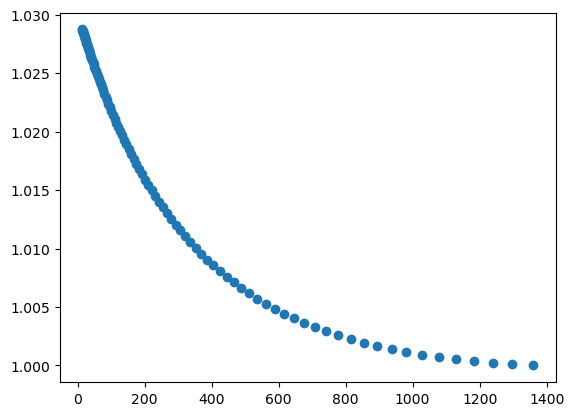

In [90]:
plt.scatter(lambda_seq_en,list_en)
plt.show()

In [49]:
# choose the valid subset of AFR training set for AFR-only model.
X_train_1 = X_train[:, col_valid_final]

# get lambda_max using kkt when beta=0, and then get lambda_seq
lambda_max = 2 * np.absolute(X_train_1.T @ y_train).max()/0.1
lambda_seq = get_lambda_seq(lambda_max, 100, 100)

# AFR-only EN model

model_en = ElasticNetCV(l1_ratio=0.1, alphas=lambda_seq, cv=kf, n_jobs=-1)
model_en.fit(X_train_1, y_train)
y_hat_test_en_1 = model_en.predict(X_test_std)
r2_en_1, m_en_1, spr2_en_1, spr_en_1 = test(y_hat_test_en_1, 'Afr')

# AFR-only lasso model
model_lasso = ElasticNetCV(l1_ratio=1, alphas=lambda_seq, cv=kf, n_jobs=-1)
model_lasso.fit(X_train_1, y_train)
y_hat_test_lasso_1 = model_lasso.predict(X_test_std)
r2_lasso_1, m_lasso_1, spr2_lasso_1, spr_lasso_1 = test(y_hat_test_lasso_1, 'Afr')

print(gene_name, r2_en_2, spr2_en_2,r2_lasso_2,spr2_lasso_2,r2_en_1, spr2_en_1, r2_lasso_1, spr2_lasso_1)

/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


nan0651 0.6116565341956068 0.384681578894118 0.6318281448531283 0.37450863241391286 nan nan nan nan


/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [45]:
model_test= ElasticNetCV(l1_ratio=0.1, n_alphas = 1000, alphas=get_lambda_seq(100, 10000, 10000), cv=kf, n_jobs=-1)
model_test

ElasticNetCV(alphas=array([1.00000000e+02, 9.99079298e+01, 9.98159444e+01, ...,
       1.00184395e-02, 1.00092155e-02, 1.00000000e-02]),
             cv=KFold(n_splits=5, random_state=None, shuffle=False),
             l1_ratio=0.1, n_alphas=1000, n_jobs=-1)

In [46]:
model_test.fit(X_train_1,y_train)
print(model_test.alpha_)
model_test.predict(X_test_std)

0.12650573406631777


array([1.00961665, 0.68070444, 0.53587235, 0.68286615, 0.68478915,
       0.5418503 , 1.2705167 , 0.57736914, 0.54057943, 0.64621737,
       1.21096052, 0.64370246, 0.5804882 , 1.2003046 , 0.69217682,
       0.70708995, 1.26951378, 0.61128943])